#Weekly Fuel Price Analysis
## Unit 4 Problem Definition and Suggested Solutions
Google Colab Notebook

# Useful links
## Data source
https://www.data.gov.uk/dataset/21db6396-3daf-4d90-8b3f-054995256018/petrol-and-diesel-prices

https://assets.publishing.service.gov.uk/media/66422e51b7249a4c6e9d3345/weekly_fuel_prices_130524.xlsx

## Programming
https://colab.research.google.com/github/datacamp/data-cleaning-with-pyspark-live-training/blob/master/notebooks/Cleaning_Data_with_PySpark.ipynb#scrollTo=2NRGmdeqa2L3

https://sparkbyexamples.com/pyspark/pyspark-split-dataframe-column-into-multiple-columns/

Below the magic %%capture suppresses output for the installation

In [1]:
%%capture
%pip install mount-azure-blob==0.0.3

In [2]:
# connection details are given in class
from mount_azure_blob import mount_storage
mount_storage(mount_path="bdv-2024-05-09t15-59-02-855z", config_file=None)


Mounting azure blob storage...
Dependencies Installed...
Successfully Mounted...


In [3]:
%%capture
# this is how you add PySpark on Google CoLab
!apt-get update # Update apt-get repository.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java.
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz # Download Apache Spark.
!tar xf spark-3.1.1-bin-hadoop3.2.tgz # Unzip the tgz file.
!pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime.

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

!ls

# Initialize findspark
import findspark
findspark.init()

# Create a PySpark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

In [4]:
# get data - in the form of an excel spreadsheet, we want a particular worksheet and will ignore some header text
import pandas as pd
pandas_df = pd.read_excel('/content/bdv-2024-05-09t15-59-02-855z/HdiSamples/weekly_fuel_prices_130524.xlsx',sheet_name='Data',skiprows=7)
pandas_df.drop([0, 7])
print('\nCheck that pandas_df is a pandas dataframe: ',isinstance(pandas_df, pd.DataFrame))


Check that pandas_df is a pandas dataframe:  True


In [5]:
pd.DataFrame.iteritems = pd.DataFrame.items # see https://stackoverflow.com/questions/75926636/databricks-issue-while-creating-spark-data-frame-from-pandas
# pull the pandas df over into Spark as a Spark df (they are not the same)
spark_df = spark.createDataFrame(pandas_df)

In [6]:
# see the result
spark_df.show()

+-------------------+----------------------------+--------------------------------------+---------------------------------------+------------------------+-----------------+--------------------------+-------------------------------------+--------------------------------------+------------------------+-----------------+
|               Date| ULSP:  Pump price (p/litre)|ULSP:  Diff on previous WEEK (p/litre)| ULSP: Diff on previous  YEAR (p/litre)|Duty rate ULSP (p/litre)|VAT (% rate) ULSP|ULSD: Pump price (p/litre)|ULSD: Diff on previous WEEK (p/litre)|ULSD: Diff on previous  YEAR (p/litre)|Duty rate ULSD (p/litre)|VAT (% rate) ULSD|
+-------------------+----------------------------+--------------------------------------+---------------------------------------+------------------------+-----------------+--------------------------+-------------------------------------+--------------------------------------+------------------------+-----------------+
|2003-06-09 00:00:00|                   

# Problem 1
## Plot average price by year for both fuel types

In [7]:
# we need to summarise by the year - to do this we will split just the year into a new column for grouping


In [11]:
from pyspark.sql.functions import year
spark_df2 = spark_df.withColumn('Year', year(spark_df['Date']))
spark_df2.printSchema() # see how the schema looks

root
 |-- Date: timestamp (nullable = true)
 |--  ULSP:  Pump price (p/litre): double (nullable = true)
 |-- ULSP:  Diff on previous WEEK (p/litre): double (nullable = true)
 |--  ULSP: Diff on previous  YEAR (p/litre): double (nullable = true)
 |-- Duty rate ULSP (p/litre): double (nullable = true)
 |-- VAT (% rate) ULSP: double (nullable = true)
 |-- ULSD: Pump price (p/litre): double (nullable = true)
 |-- ULSD: Diff on previous WEEK (p/litre): double (nullable = true)
 |-- ULSD: Diff on previous  YEAR (p/litre): double (nullable = true)
 |-- Duty rate ULSD (p/litre): double (nullable = true)
 |-- VAT (% rate) ULSD: double (nullable = true)
 |-- Year: integer (nullable = true)



In [12]:
spark_df3 = spark_df2.drop(spark_df2.Date) # we can drop the date column now, but as spark df's are immutable, we need to create another
spark_df3.printSchema() # see how the schema looks

root
 |--  ULSP:  Pump price (p/litre): double (nullable = true)
 |-- ULSP:  Diff on previous WEEK (p/litre): double (nullable = true)
 |--  ULSP: Diff on previous  YEAR (p/litre): double (nullable = true)
 |-- Duty rate ULSP (p/litre): double (nullable = true)
 |-- VAT (% rate) ULSP: double (nullable = true)
 |-- ULSD: Pump price (p/litre): double (nullable = true)
 |-- ULSD: Diff on previous WEEK (p/litre): double (nullable = true)
 |-- ULSD: Diff on previous  YEAR (p/litre): double (nullable = true)
 |-- Duty rate ULSD (p/litre): double (nullable = true)
 |-- VAT (% rate) ULSD: double (nullable = true)
 |-- Year: integer (nullable = true)



In [126]:
# Time series prediction
# Use FaceBook Prophet - https://facebook.github.io/prophet/docs/quick_start.html
from prophet import Prophet

costs = pandas_df[['Date', ' ULSP:  Pump price (p/litre)']]
costs.columns = ["ds", "y"]

model = Prophet()
model.fit(costs)



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpemb728__/f3rhtfme.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpemb728__/z6ideu4l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35836', 'data', 'file=/tmp/tmpemb728__/f3rhtfme.json', 'init=/tmp/tmpemb728__/z6ideu4l.json', 'output', 'file=/tmp/tmpemb728__/prophet_model8uvjuh5x/prophet_model-20241120013515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:35:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:35:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


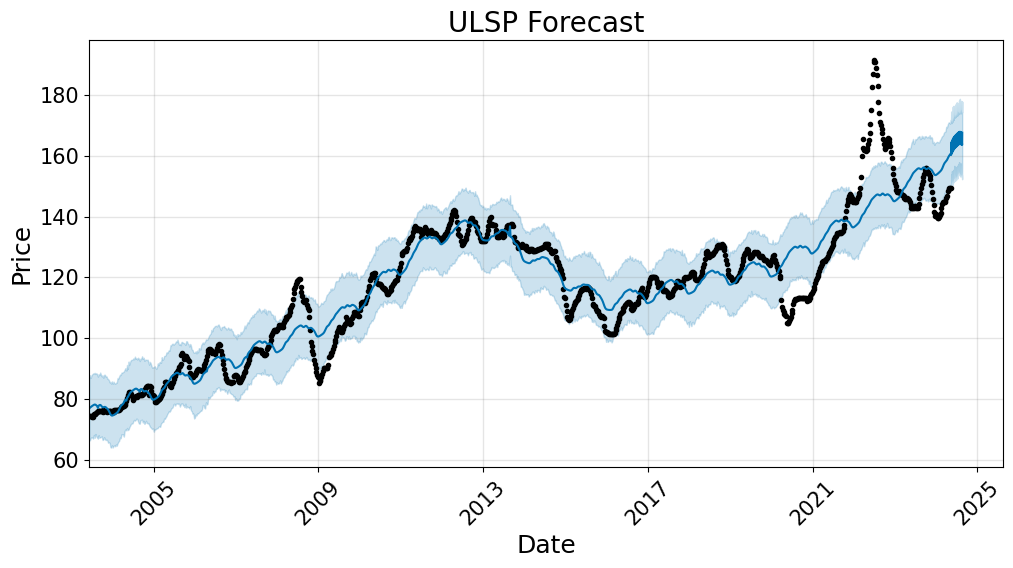

In [130]:

# Import library
import datetime

# Create a data frame for predictions with dates from 13/5/2024 - 21/8/2025
future = model.make_future_dataframe(periods=100)

# Change the column name
future.columns = ['ds']
#future.tail()
# in-sample prediction
prediction = model.predict(future)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("ULSP Forecast", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("Price", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2003-06-09', '2025-08-21']))
plt.show();

In [10]:
# Here's an alternatiive approach we could have used for splitting up the date
# Use pyspark split, to get this we need to first load in the sql functions
#from pyspark.sql import functions as F
#spark_df2 = spark_df.withColumn('Year', F.split(spark_df['Date'], '-').getItem(0)) \
#       .withColumn('Month', F.split(spark_df['Date'], '-').getItem(1)) \
#       .withColumn('Day', F.split(spark_df['Date'], '-').getItem(2))

In [13]:
# now we can do the grouping by year before we plot it out
# note the way the com mands can be chained together with the full stop seperator, note finally the toPandas() converts the spark df to pandas - for the graphing
pd_df = spark_df3.groupby('Year').avg().sort('Year', ascending=[True]).toPandas()
pd_df.set_index(['Year'],drop=True, inplace=True) # an index is needed for the x axis in plots

#from IPython.display import display # print out the result if we want to see the data table
#display(pd_df)
pd_df.info() # print schema to check col names
print('\nCheck that pd_df is a pandas dataframe: ',isinstance(pd_df, pd.DataFrame)) # check it's a panda df

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 2003 to 2024
Data columns (total 11 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   avg( ULSP:  Pump price (p/litre))             22 non-null     float64
 1   avg(ULSP:  Diff on previous WEEK (p/litre))   21 non-null     float64
 2   avg( ULSP: Diff on previous  YEAR (p/litre))  20 non-null     float64
 3   avg(Duty rate ULSP (p/litre))                 22 non-null     float64
 4   avg(VAT (% rate) ULSP)                        22 non-null     float64
 5   avg(ULSD: Pump price (p/litre))               22 non-null     float64
 6   avg(ULSD: Diff on previous WEEK (p/litre))    21 non-null     float64
 7   avg(ULSD: Diff on previous  YEAR (p/litre))   20 non-null     float64
 8   avg(Duty rate ULSD (p/litre))                 22 non-null     float64
 9   avg(VAT (% rate) ULSD)                        22 non-null     float

Text(0, 0.5, 'Fuel Pump Price (p/Litre)')

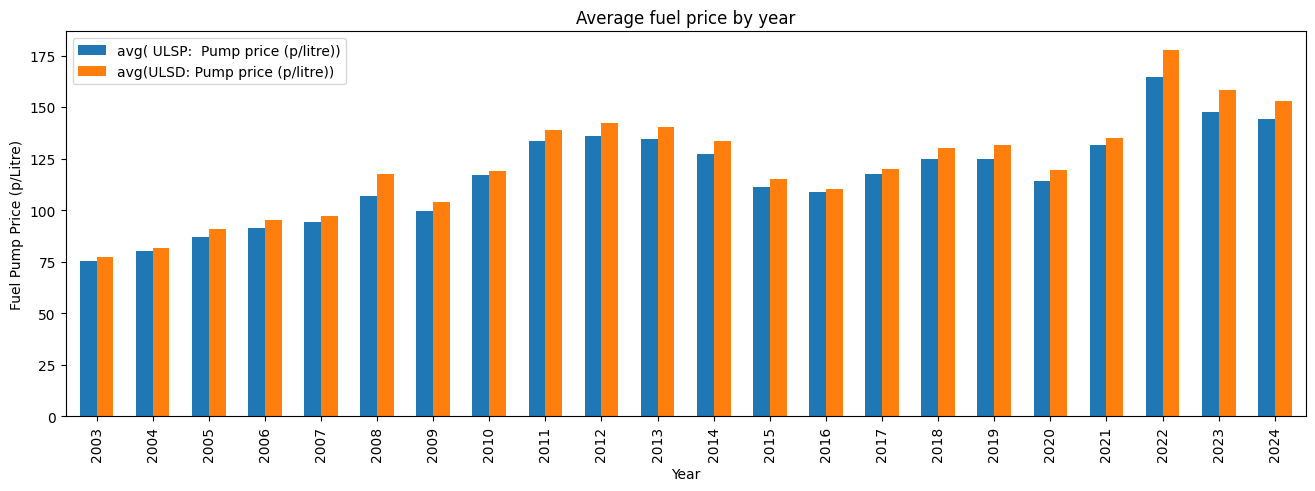

In [16]:
import matplotlib.pyplot as plt
pd_df[['avg( ULSP:  Pump price (p/litre))', 'avg(ULSD: Pump price (p/litre))']].plot(kind="bar", stacked=False, width=0.6, figsize=(16, 5))
plt.title('Average fuel price by year')
plt.xlabel('Year')
plt.ylabel('Fuel Pump Price (p/Litre)')

Text(0, 0.5, 'Fuel Pump Price (p/Litre)')

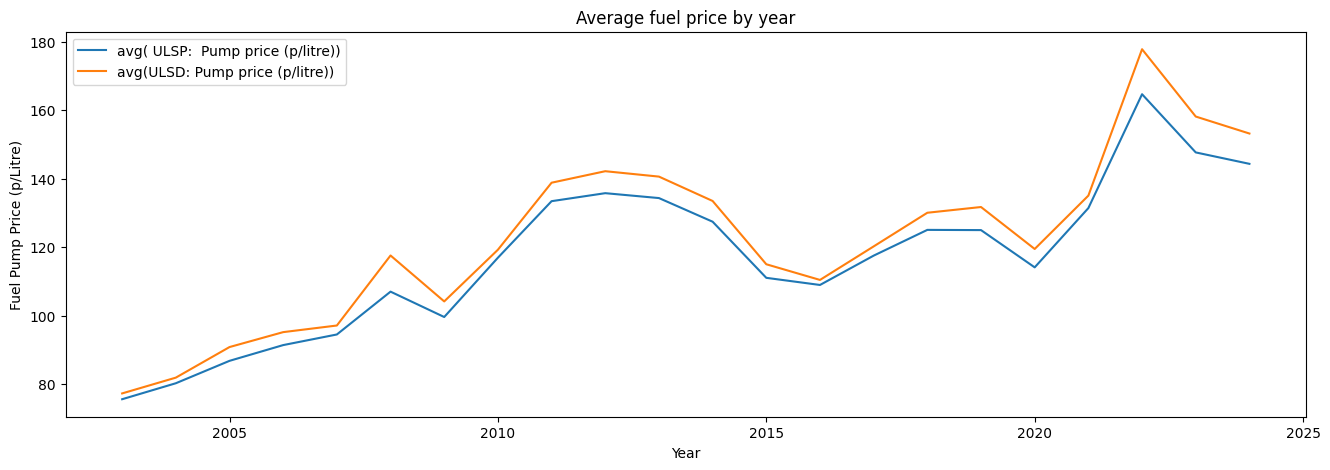

In [32]:
import matplotlib.pyplot as plt
pd_df[['avg( ULSP:  Pump price (p/litre))', 'avg(ULSD: Pump price (p/litre))']].plot(kind="line", figsize=(16, 5))
plt.title('Average fuel price by year')
plt.xlabel('Year')
plt.ylabel('Fuel Pump Price (p/Litre)')

# Take a moment at this point to explore the Gemini AI feature to 'explain the code' - this can help your learning! Select the small star icon to the right.

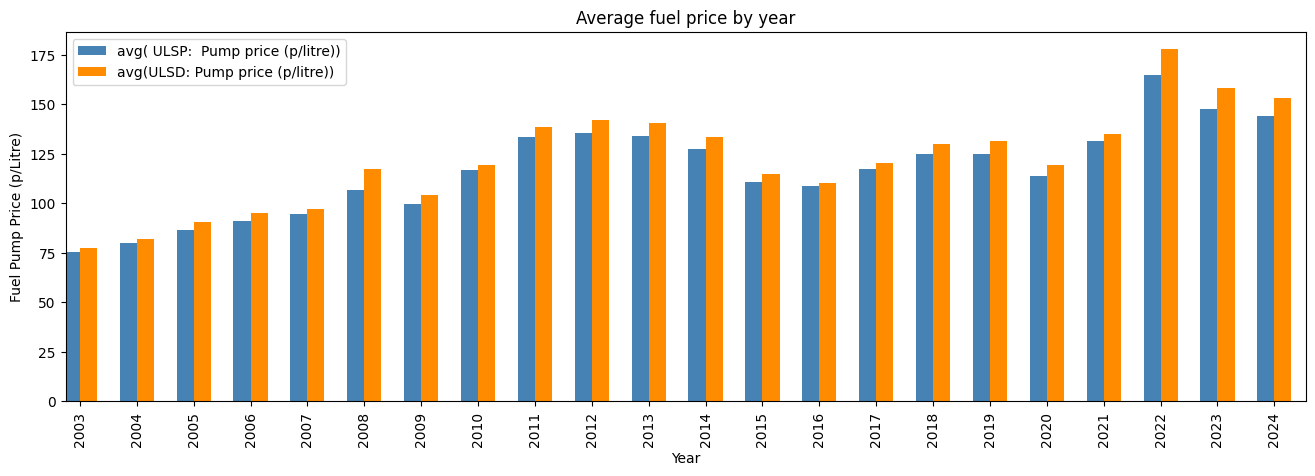

In [19]:
# Here's an alternative bar chart form - the approach above seems simpler!
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_figwidth(16)
axes = plt.axes()
width = 0.3
plt.title('Average fuel price by year')
plt.xlabel('Year')
plt.ylabel('Fuel Pump Price (p/Litre)')
axes.xaxis.set_tick_params(rotation=90)
pd_df.plot(color='steelblue', y='avg( ULSP:  Pump price (p/litre))', width=width, position=1, legend=True, kind='bar', ax=axes)
pd_df.plot(color='darkorange', y='avg(ULSD: Pump price (p/litre))', width=width, position=0, legend=True, kind='bar', ax=axes)
plt.show() # for colours, see https://matplotlib.org/2.0.2/examples/color/named_colors.html

# Problem 2
## Price variation by year

In [22]:
# Distribution of fuel prices in each year
pd_df_box = spark_df3.sort("Year", ascending=[True]).toPandas()
spark_df3.printSchema()

root
 |--  ULSP:  Pump price (p/litre): double (nullable = true)
 |-- ULSP:  Diff on previous WEEK (p/litre): double (nullable = true)
 |--  ULSP: Diff on previous  YEAR (p/litre): double (nullable = true)
 |-- Duty rate ULSP (p/litre): double (nullable = true)
 |-- VAT (% rate) ULSP: double (nullable = true)
 |-- ULSD: Pump price (p/litre): double (nullable = true)
 |-- ULSD: Diff on previous WEEK (p/litre): double (nullable = true)
 |-- ULSD: Diff on previous  YEAR (p/litre): double (nullable = true)
 |-- Duty rate ULSD (p/litre): double (nullable = true)
 |-- VAT (% rate) ULSD: double (nullable = true)
 |-- Year: integer (nullable = true)



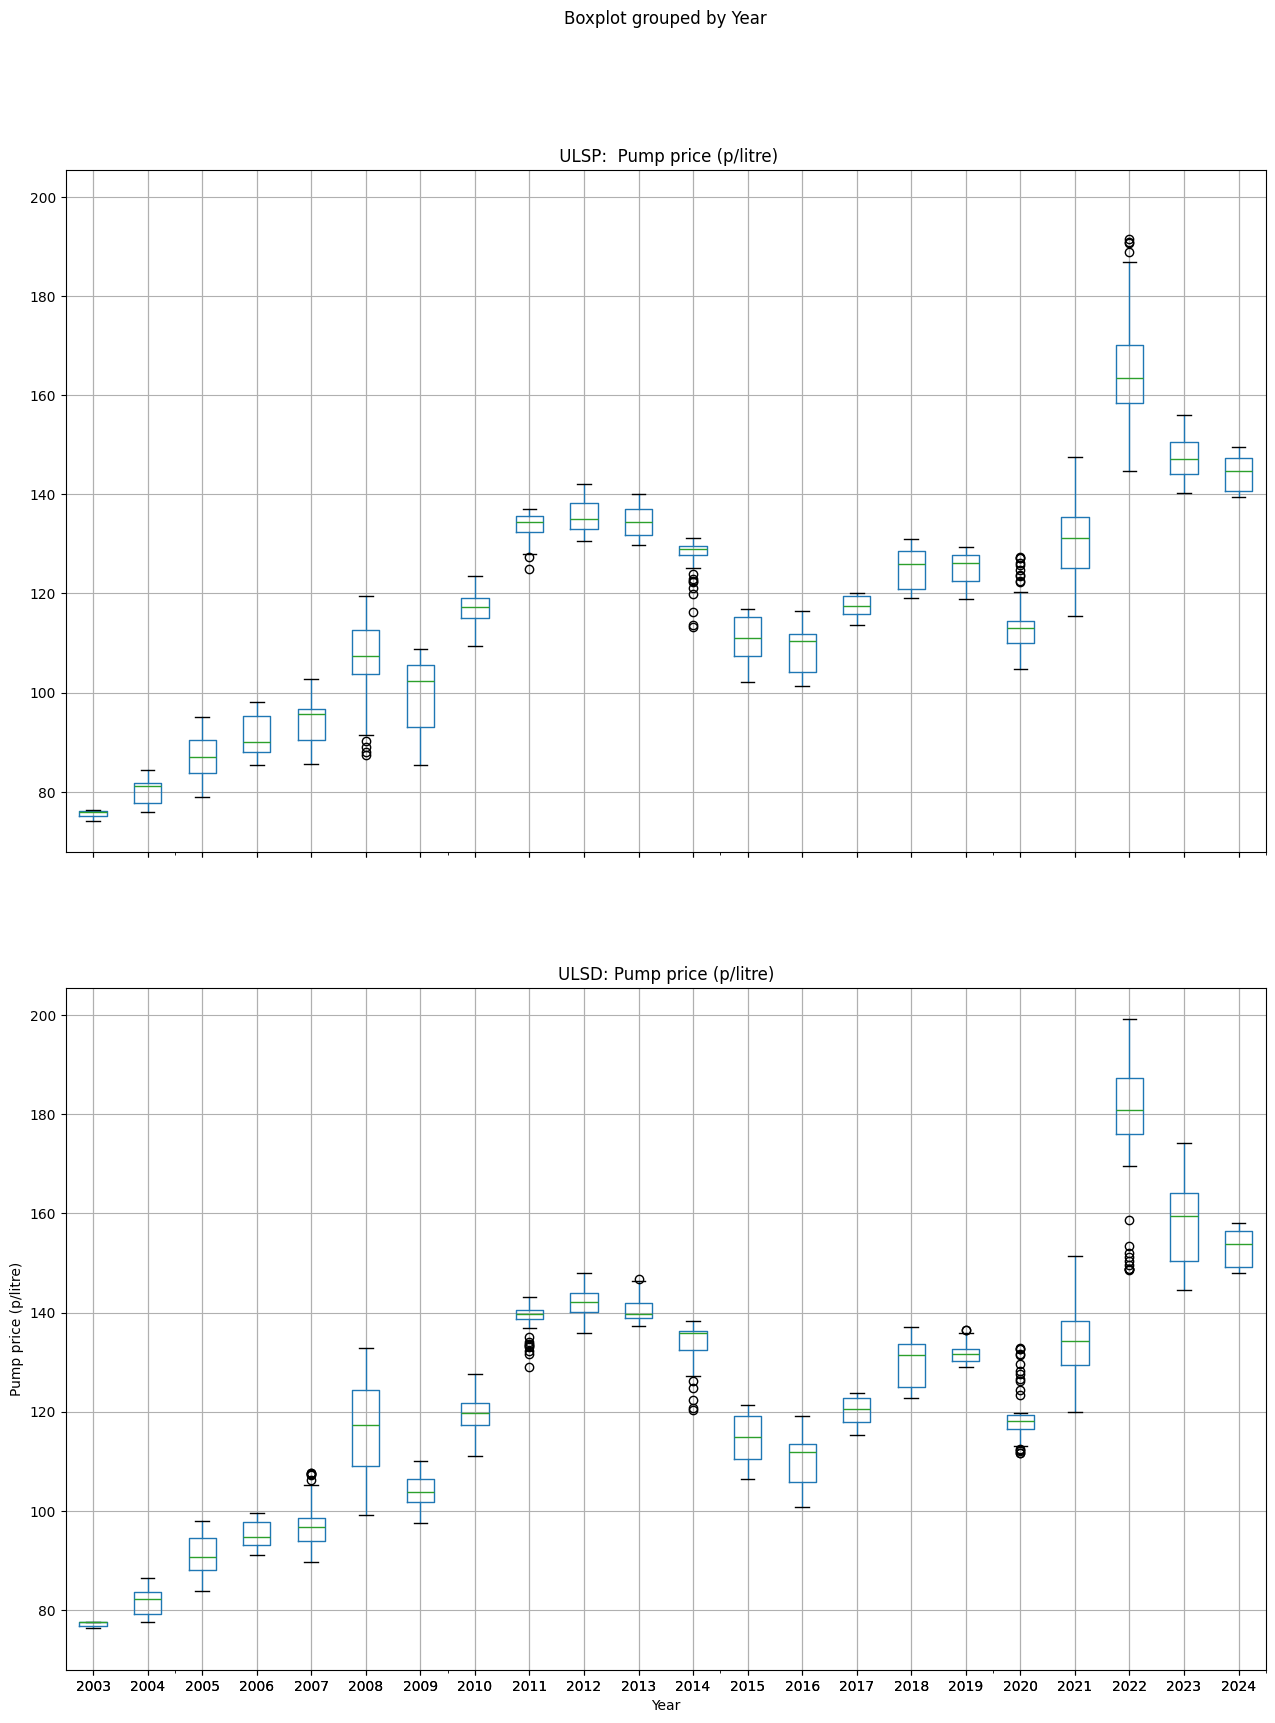

In [29]:
axes = pd_df_box.boxplot(figsize = (15,20), fontsize= '10', grid = True, by = 'Year', column = [' ULSP:  Pump price (p/litre)','ULSD: Pump price (p/litre)'], layout=(2, 1))
#plt.title('Variation in USLP fuel prices by year (2003-2024)')
plt.xlabel('Year') # set up the horizontal 'x' axis label
plt.ylabel('Pump price (p/litre)') # set up the vertical 'y' axis label
plt.show()
# note, the boxes extend from the Q1 to Q3 quartile values of the data, with a line at the median (Q2), outliers are plotted as separate dots.

# Problem 3
## Additional visualisations
A final challenge, made all the easier by Google CoLab is to see some other potential visualisations of the data.

In CoLab, if you present a Pandas dataframe with the 'display' command as below, CoLab places an option below offering auto-generation of a wide range of graph types. Selecting any of these graphs will provide a further option to show the generated code to produce that graph - very helpful! Click on 'View recommended plots' below the table, then select a graph to see its source code.

In [24]:
from IPython.display import display # print out the result if we want to see the data table
display(pd_df)

,avg( ULSP: Pump price (p/litre)),avg(ULSP: Diff on previous WEEK (p/litre)),avg( ULSP: Diff on previous YEAR (p/litre)),avg(Duty rate ULSP (p/litre)),avg(VAT (% rate) ULSP),avg(ULSD: Pump price (p/litre)),avg(ULSD: Diff on previous WEEK (p/litre)),avg(ULSD: Diff on previous YEAR (p/litre)),avg(Duty rate ULSD (p/litre)),avg(VAT (% rate) ULSD),avg(Year)
Year,,,,,,,,,,,
2003,75.591537,NaN,NaN,46.374667,17.500000,77.287333,NaN,NaN,46.374667,17.500000,2003.0
2004,80.254930,0.098905,NaN,47.100000,17.500000,81.894003,0.140765,NaN,47.100000,17.500000,2004.0
2005,86.796860,0.128936,6.541930,47.100000,17.500000,90.820266,0.132915,8.926263,47.100000,17.500000,2005.0
2006,91.395871,-0.000042,4.598636,47.172115,17.500000,95.179094,0.024717,4.358828,47.172115,17.500000,2006.0
2007,94.495094,0.280087,3.166066,48.878302,17.500000,97.112432,0.268504,1.966864,48.878302,17.500000,2007.0
2008,107.001178,-0.293709,12.378355,50.542308,17.259615,117.556702,-0.162800,20.372919,50.542308,17.259615,2008.0
2009,99.593804,0.388567,-7.407375,54.383846,15.000000,104.146614,0.192734,-13.410088,54.383846,15.000000,2009.0
2010,116.904146,0.305704,17.310342,57.190000,17.500000,119.234615,0.354183,15.088001,57.190000,17.500000,2010.0
2011,133.412774,0.172037,16.508628,58.180769,19.951923,138.805382,0.252479,19.570768,58.180769,19.951923,2011.0
